In [1]:
"""
%pip install --upgrade pip && pip install -q "tensorflow>=2.16" && \
pip install pandas && pip install matplotlib && \
pip install scikit-learn && pip install seaborn && pip install kagglehub
"""

'\n%pip install --upgrade pip && pip install -q "tensorflow>=2.16" && pip install pandas && pip install matplotlib && pip install scikit-learn && pip install seaborn && pip install kagglehub\n'

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten, Dropout, Dense, Conv2D, MaxPool2D
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

2026-02-20 16:35:52.959567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset Setup
### Download the NEU Surface Defect Database

Option 1: Using kagglehub (recommended)
```python
import kagglehub
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")
print("Path to dataset files:", path)
```

Option 2: Manual download
1. Download from [Kaggle](https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database)
2. Extract to a folder named `data` in your workspace

Once downloaded, your directory structure should look like:
```
data/
├── train/
│   └── images/
│       ├── crazing/
│       ├── inclusion/
│       ├── patches/
│       ├── pitted/
│       ├── rolled/
│       └── scratches/
└── validation/
    └── images/
        ├── crazing/
        ├── inclusion/
        ├── patches/
        ├── pitted/
        ├── rolled/
        └── scratches/
```

In [2]:
# Option 1: Download using kagglehub
import kagglehub
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")

# Define paths for train and validation data
train_path_img = os.path.join(path, "NEU-DET", "train", "images")
validation_path_img = os.path.join(path, "NEU-DET", "validation", "images")

/Users/marziehsaeedi/workshop-deeplearning/defect-classification/dl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get sorted class names for consistency
train_classes = sorted(os.listdir(train_path_img))
class_names = train_classes
print(f"Classes found: {class_names}")
print(f"Number of classes: {len(class_names)}")

Classes found: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Number of classes: 6


In [4]:
# Load training and validation datasets
BATCH_SIZE = 32
IMAGE_SIZE = 255

# Load training dataset with explicit class names
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=train_path_img,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_names=class_names,
    shuffle=True,
    seed=100
)
print(f"Training dataset: {train_dataset}")

# Load validation dataset with same class names order
val_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=validation_path_img,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_names=class_names,
    shuffle=False,
    seed=100
)

Found 1440 files belonging to 6 classes.
Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>
Found 360 files belonging to 6 classes.


Image shape: (32, 255, 255, 3)
Labels shape: (32, 6)
Labels: [[0. 1. 0. 0. 0. 0.]]


2026-02-20 16:36:56.084825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-20 16:36:56.482564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


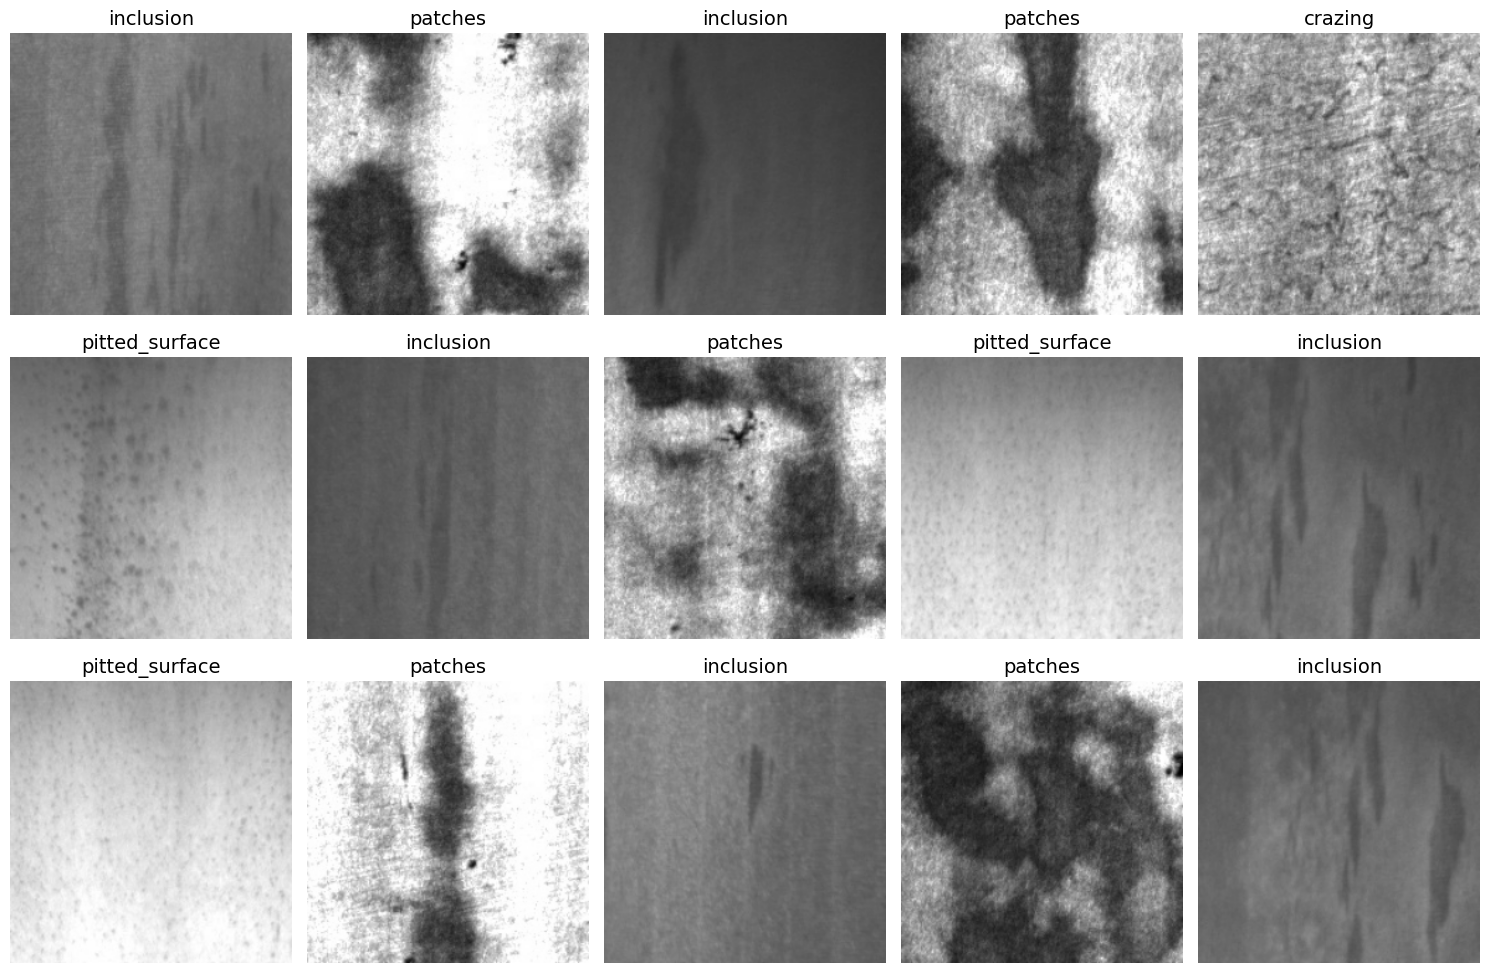

In [7]:
# Visualize sample images from dataset
for images, labels in train_dataset.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels [:1].numpy()}")

# Display 15 sample images
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(15, len(images))):
        ax = plt.subplot(3, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = int(np.argmax(labels[i].numpy()))
        plt.title(class_names[label_idx], fontsize=14)
        plt.axis('off')
plt.tight_layout()
plt.show()

## LeNet Model
**LeNet** is a classic convolutional neural network architecture designed by Yann LeCun in 1998, originally for handwritten digit recognition.

<p align="center">
    <img src="images/lenet.png" alt="LeNet architecture diagram" width="900"/>
</p>


In [9]:
# Preprocessing layers
Resize_Rescale = keras.Sequential([
    keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.Rescaling(1./255)
])

# Data augmentation layers
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomZoom(0.1)
])

# Build LeNet model
model_lenet = keras.Sequential([
    Resize_Rescale,
    data_augmentation,
    
    # First convolutional layer
    keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    keras.layers.MaxPool2D((2, 2)),
    
    # Second convolutional layer
    keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    
    # Flatten
    keras.layers.Flatten(),
    
    # Fully connected layers
    keras.layers.Dense(120, activation='relu'),
    keras.layers.Dense(84, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model_lenet.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
model_lenet.summary()

/Users/marziehsaeedi/workshop-deeplearning/defect-classification/dl_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 251, 251, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 125, 125, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 121, 121, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 60, 60, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 57600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 120)              │     6,912,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 84)               │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 6)                │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,925,666 (26.42 MB)

 Trainable params: 6,925,666 (26.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHES=5
model_lenet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model_lenet.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=EPOCHES)

Epoch 1/5


45/45 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.2993 - loss: 1.6003 - val_accuracy: 0.3611 - val_loss: 1.7735
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4375 - loss: 1.2918 - val_accuracy: 0.4556 - val_loss: 1.2239
Epoch 3/5
10/45 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5794 - loss: 1.0709

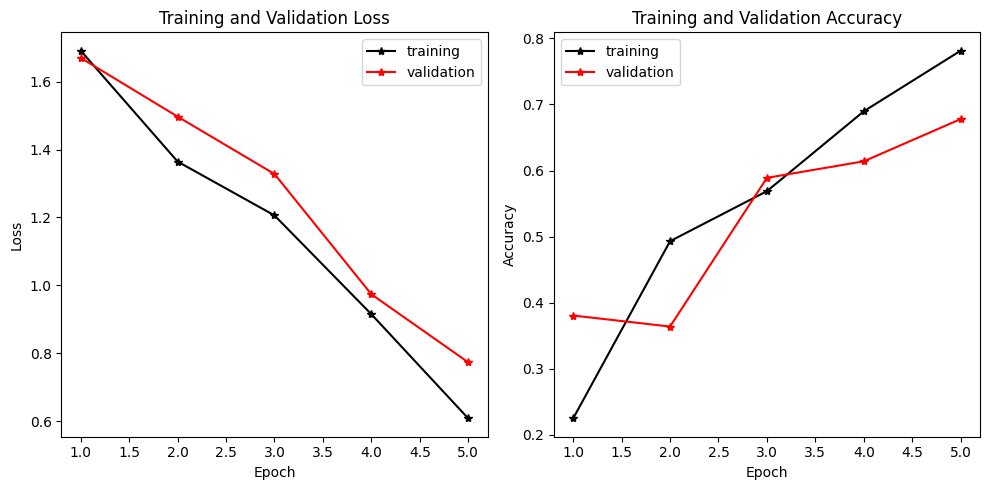

In [9]:
# Plot training history - Loss and Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, EPOCHES+1), history.history['loss'], color='black', label='training', marker='*')
plt.plot(np.arange(1, EPOCHES+1), history.history['val_loss'], color='red', label='validation', marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, EPOCHES+1), history.history['accuracy'], color='black', label='training', marker='*')
plt.plot(np.arange(1, EPOCHES+1), history.history['val_accuracy'], color='red', label='validation', marker='*')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


2026-02-20 11:29:34.322795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


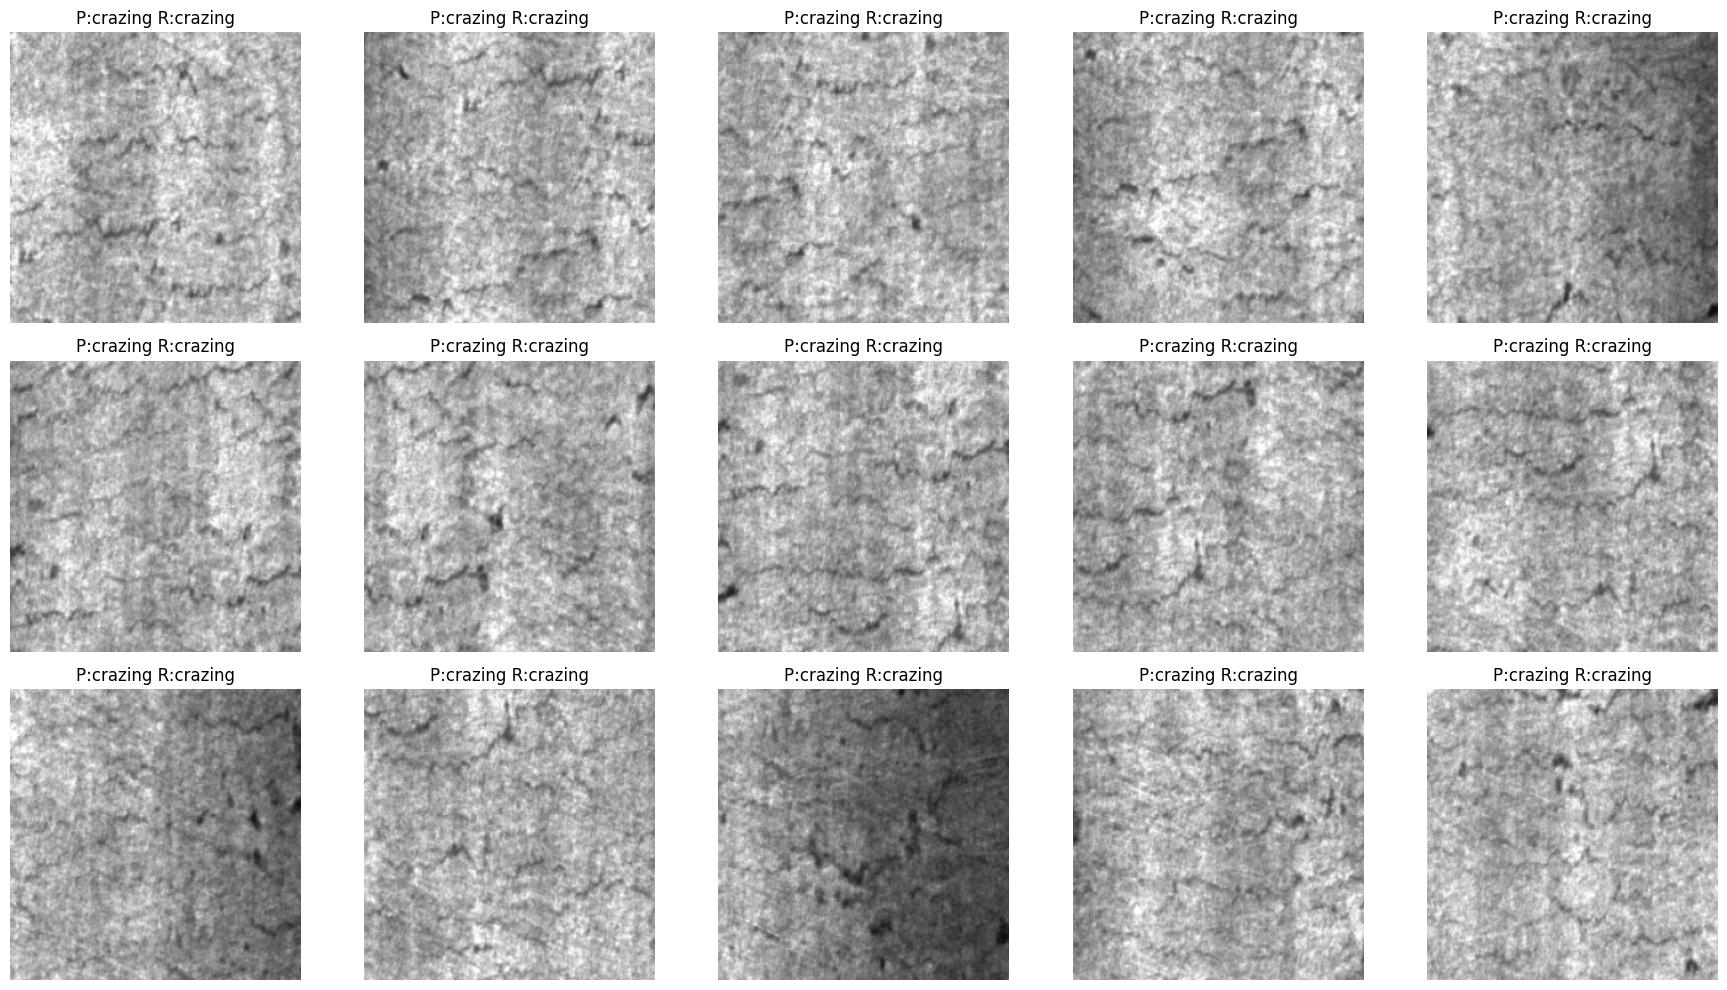

In [10]:
# Visualize predictions on validation set
plt.figure(figsize=(18, 10))
for images, labels in val_dataset.take(1):
    ypred = model.predict(images)
    ypred = [np.argmax(i) for i in ypred]
    for i in range(0, 15):
        ax = plt.subplot(3, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_class = np.argmax(labels[i].numpy())
        plt.title(f"P:{class_names[ypred[i]]} R:{class_names[actual_class]}")
        plt.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


2026-02-20 11:29:41.060260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


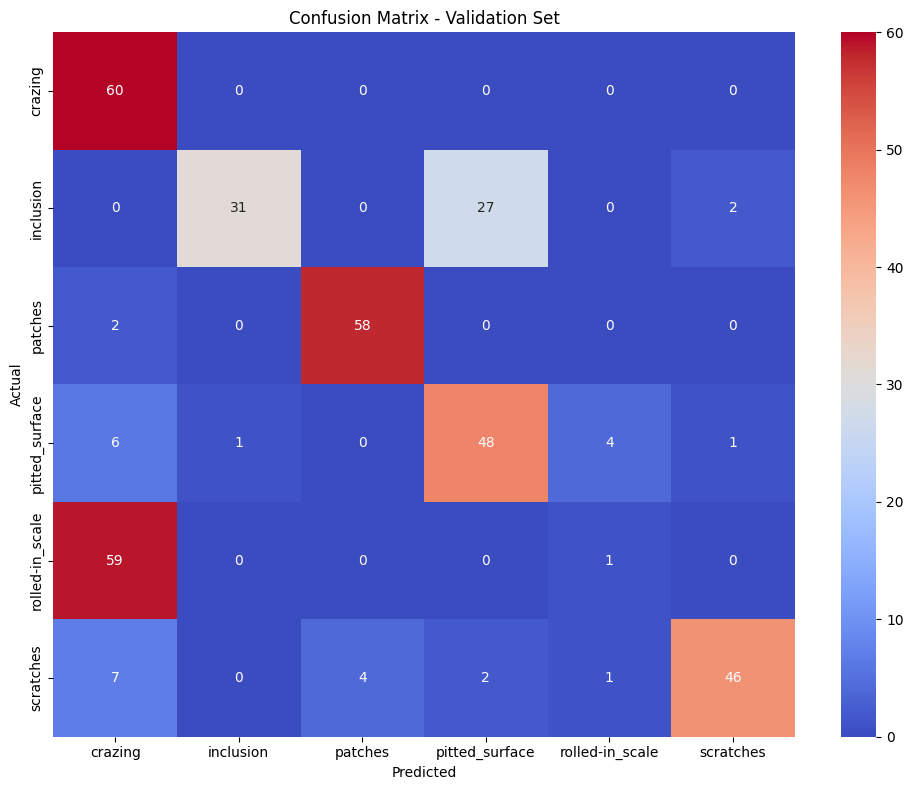


Classification Report:
                 precision    recall  f1-score   support

        crazing       0.45      1.00      0.62        60
      inclusion       0.97      0.52      0.67        60
        patches       0.94      0.97      0.95        60
 pitted_surface       0.62      0.80      0.70        60
rolled-in_scale       0.17      0.02      0.03        60
      scratches       0.94      0.77      0.84        60

       accuracy                           0.68       360
      macro avg       0.68      0.68      0.64       360
   weighted avg       0.68      0.68      0.64       360



In [11]:
# Compute confusion matrix and classification report on all validation data
ypred_tot = []
label_tot = []

for images, labels in val_dataset:
    ypred_test = model.predict(images)
    ypred_test = [np.argmax(i) for i in ypred_test]
    ypred_tot.extend(ypred_test)
    label_tot.extend([np.argmax(label) for label in labels.numpy()])

# Create confusion matrix
cm = tf.math.confusion_matrix(label_tot, ypred_tot, num_classes=len(class_names))

# Display confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="coolwarm", xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.tight_layout()
plt.show()

# Print classification report with all labels
print("\nClassification Report:")
print(classification_report(label_tot, ypred_tot, labels=range(len(class_names)), target_names=class_names))